# PRCP- 1001- RICE LEAF DISEASE DETECTION

## DOMAIN ANALYSIS

---

### Domain Background – Agriculture & Crop Disease

Agriculture remains a primary economic sector in many countries, and rice is one of the world’s most consumed staple crops. However, rice is particularly susceptible to numerous leaf diseases that reduce yield and quality. Manual diagnosis of these diseases is:

- **Time-consuming**
- **Labor-intensive**
- **Prone to human error**

The integration of **AI-based image recognition**, especially using **Convolutional Neural Networks (CNNs)**, has emerged as a game-changer for crop disease detection. CNNs can automatically extract patterns from leaf images to accurately detect disease types, even under noisy or varied conditions.

---

### Project Objective

The objective of this project is to build a **robust image classification model** using deep learning and transfer learning techniques to classify rice leaf images into three categories:

- **Bacterial Leaf Blight**
- **Brown Spot**
- **Leaf Smut**

This model aims to:

- Achieve high **classification accuracy and generalization**
- Be scalable for **real-world deployment (e.g., web/mobile apps)**
- Help **farmers or agronomists** with early, accurate diagnosis

---

### Dataset Description

- The dataset consists of rice leaf images categorized into **three classes**:  
  - *Bacterial leaf blight*  
  - *Brown spot*  
  - *Leaf smut*

- Each image is in `.JPG` format and was manually labeled.
- Data split:
  - 70% Training
  - 15% Validation
  - 15% Testing

---

### Problem Framing

- **Task Type**: Multiclass Image Classification
- **Learning Approach**: Supervised Learning
- **Input**: Raw image (RGB, 224x224)
- **Output**: Class label (0, 1, 2)

---

### Importance of Automation

- Early disease detection → Reduces economic losses
- Eliminates manual bias in inspection
- Enables **scalable**, **real-time**, and **remote diagnosis** for smart agriculture


## PRECHECKS

In [1]:
import seaborn as sns
import os
import random
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

Dataset structure is valid in: ./Data

Class Distribution:
 - Bacterial leaf blight: 40 images
 - Brown spot: 40 images
 - Leaf smut: 39 images


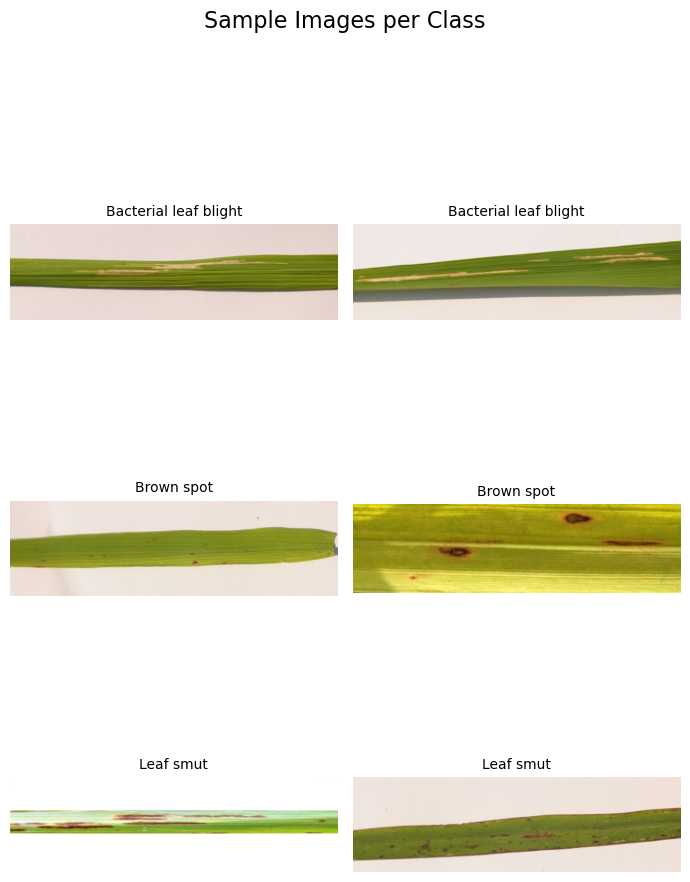

In [2]:
# Set base folder and expected subfolders
base_folder = "./Data"
expected_classes = ['Leaf smut', 'Brown spot', 'Bacterial leaf blight']

# Validate dataset structure
if not os.path.exists(base_folder):
    raise FileNotFoundError(f"Data folder not found at path: {base_folder}")

missing_classes = [cls for cls in expected_classes if not os.path.isdir(os.path.join(base_folder, cls))]
if missing_classes:
    raise FileNotFoundError(f"Missing expected class folders: {missing_classes}")
else:
    print(f"Dataset structure is valid in: {base_folder}")

# Get class list dynamically (optional, for flexibility)
classes = sorted([folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder))])

# Count number of images per class
class_counts = defaultdict(int)
for cls in classes:
    class_dir = os.path.join(base_folder, cls)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[cls] = len(images)

print("\nClass Distribution:")
for cls, count in class_counts.items():
    print(f" - {cls}: {count} images")

# Show sample images per class
def show_sample_images(dataset_path, class_names, samples_per_class=2):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3.5, len(class_names) * 3.5))

    for i, cls in enumerate(class_names):
        img_dir = os.path.join(dataset_path, cls)
        image_files = [img for img in os.listdir(img_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(image_files) < samples_per_class:
            raise ValueError(f"Not enough images in class '{cls}' to sample {samples_per_class}.")

        selected_imgs = random.sample(image_files, samples_per_class)
        for j, img_file in enumerate(selected_imgs):
            img_path = os.path.join(img_dir, img_file)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{cls}", fontsize=10)
    plt.tight_layout()
    plt.suptitle("Sample Images per Class", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

# Visualize
show_sample_images(base_folder, classes, samples_per_class=2)


## Import & Organize Data

In [3]:
# Function to gather image file paths per class
def get_image_data_dict(base_folder, class_names):
    data = []
    for cls in class_names:
        cls_folder = os.path.join(base_folder, cls)
        img_files = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        for img in img_files:
            full_path = os.path.join(cls_folder, img)
            data.append({'image_path': full_path, 'class_label': cls})
    return pd.DataFrame(data)

# Get DataFrame of all images and labels
image_df = get_image_data_dict(base_folder, classes)
print(f"Total images collected: {len(image_df)}")
image_df.head()


Total images collected: 119


,image_path,class_label
0,./Data\Bacterial leaf blight\DSC_0365.JPG,Bacterial leaf blight
1,./Data\Bacterial leaf blight\DSC_0366.jpg,Bacterial leaf blight
2,./Data\Bacterial leaf blight\DSC_0367.JPG,Bacterial leaf blight
3,./Data\Bacterial leaf blight\DSC_0370.jpg,Bacterial leaf blight
4,./Data\Bacterial leaf blight\DSC_0372.JPG,Bacterial leaf blight


## EDA

C:\Users\prasa\AppData\Local\Temp\ipykernel_14208\32589907.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=image_df, x='class_label', order=classes, palette='Set2')


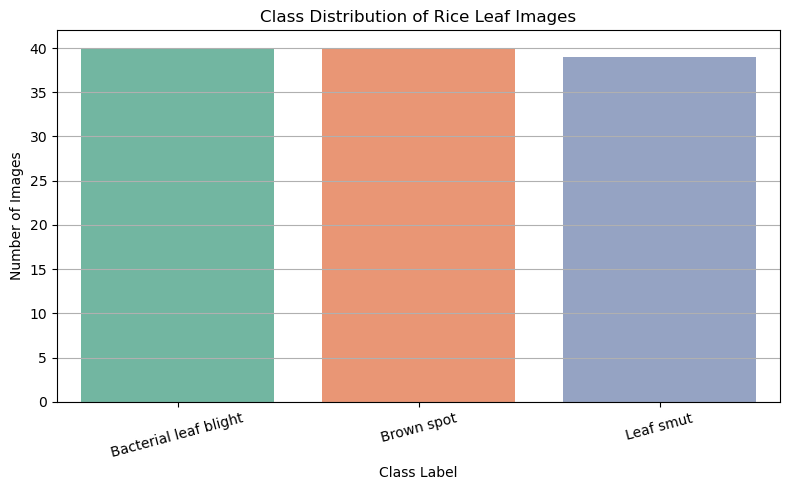

In [4]:
# Plot class distribution as a bar plot
plt.figure(figsize=(8, 5))
sns.countplot(data=image_df, x='class_label', order=classes, palette='Set2')
plt.title("Class Distribution of Rice Leaf Images")
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [5]:
# Add image metadata columns
def extract_metadata(df):
    widths = []
    heights = []
    aspect_ratios = []
    file_sizes = []

    for path in df['image_path']:
        img = Image.open(path)
        width, height = img.size
        aspect_ratios.append(round(width / height, 2))
        widths.append(width)
        heights.append(height)
        file_sizes.append(os.path.getsize(path) / 1024)  # in KB

    df['width'] = widths
    df['height'] = heights
    df['aspect_ratio'] = aspect_ratios
    df['file_size_kb'] = file_sizes
    return df

image_df = extract_metadata(image_df)
image_df.head()


,image_path,class_label,width,height,aspect_ratio,file_size_kb
0,./Data\Bacterial leaf blight\DSC_0365.JPG,Bacterial leaf blight,3081,897,3.43,456.161133
1,./Data\Bacterial leaf blight\DSC_0366.jpg,Bacterial leaf blight,3081,897,3.43,408.133789
2,./Data\Bacterial leaf blight\DSC_0367.JPG,Bacterial leaf blight,3081,897,3.43,442.016602
3,./Data\Bacterial leaf blight\DSC_0370.jpg,Bacterial leaf blight,3081,897,3.43,418.683594
4,./Data\Bacterial leaf blight\DSC_0372.JPG,Bacterial leaf blight,3081,897,3.43,470.204102


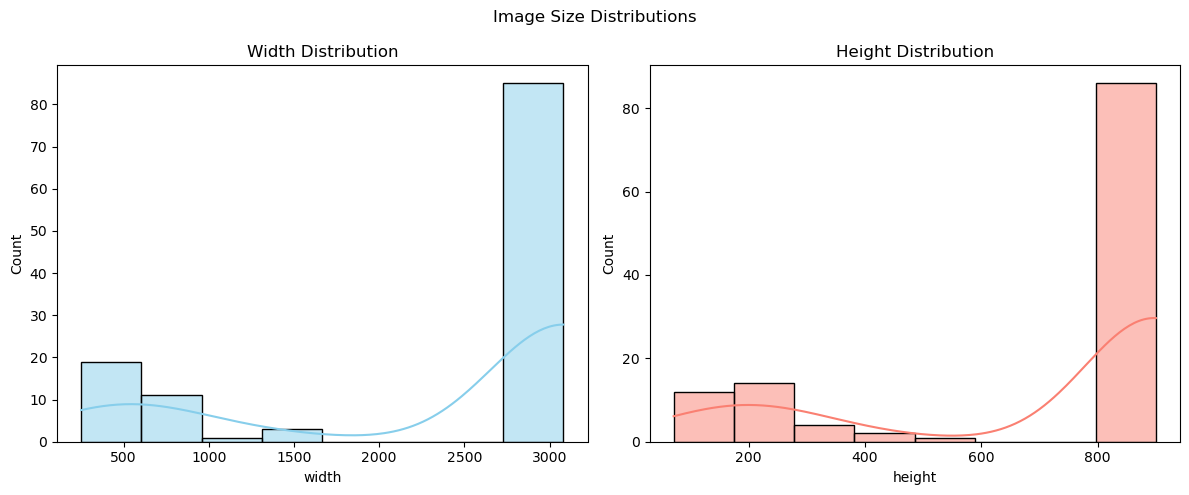

In [6]:
# Width and Height distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(image_df['width'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title("Width Distribution")

sns.histplot(image_df['height'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title("Height Distribution")

plt.suptitle("Image Size Distributions")
plt.tight_layout()
plt.show()


In [7]:
label_counts = image_df['class_label'].value_counts()
label_percentages = (label_counts / len(image_df)) * 100

label_df = pd.DataFrame({
    'Class': label_counts.index,
    'Count': label_counts.values,
    'Percentage': label_percentages.round(2)
})

print("Class Label Summary:\n")
print(label_df)


Class Label Summary:

                                       Class  Count  Percentage
class_label                                                    
Bacterial leaf blight  Bacterial leaf blight     40       33.61
Brown spot                        Brown spot     40       33.61
Leaf smut                          Leaf smut     39       32.77


## Data Preprocessing & Augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Image shape for all models (we'll use a commonly accepted 224x224x3 for transfer learning compatibility)
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16
SEED = 42


In [9]:
import shutil

def prepare_directory_split(df, base_output_dir, split_ratio=(0.7, 0.15, 0.15)):
    
    # Remove existing split if any
    if os.path.exists(base_output_dir):
        shutil.rmtree(base_output_dir)
    
    subsets = ['train', 'val', 'test']
    split_dfs = {}

    # Split the data
    df_train, df_temp = train_test_split(df, test_size=1-split_ratio[0], stratify=df['class_label'], random_state=SEED)
    val_ratio_adjusted = split_ratio[1] / (split_ratio[1] + split_ratio[2])
    df_val, df_test = train_test_split(df_temp, test_size=1 - val_ratio_adjusted, stratify=df_temp['class_label'], random_state=SEED)

    split_dfs['train'] = df_train
    split_dfs['val'] = df_val
    split_dfs['test'] = df_test

    # Copy images to destination folders
    for subset in subsets:
        for cls in df['class_label'].unique():
            dest_dir = os.path.join(base_output_dir, subset, cls)
            os.makedirs(dest_dir, exist_ok=True)

        for _, row in split_dfs[subset].iterrows():
            src = row['image_path']
            dst = os.path.join(base_output_dir, subset, row['class_label'], os.path.basename(src))
            shutil.copy2(src, dst)

    print(f"Dataset split into train/val/test and copied to: {base_output_dir}")

# Run it
split_base_dir = './PreparedData'
prepare_directory_split(image_df, base_output_dir=split_base_dir)


Dataset split into train/val/test and copied to: ./PreparedData


In [10]:
# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(split_base_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(split_base_dir, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_generator = val_test_datagen.flow_from_directory(
    directory=os.path.join(split_base_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# Label Mapping
class_indices = train_generator.class_indices
print("Class to Index Mapping:", class_indices)


Found 83 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Class to Index Mapping: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


## Dataset Splitting & Pipeline Preparation

In [11]:
# Print the number of images in each set
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Testing samples: {test_generator.samples}")

# Print class index mapping
print("Class Index Mapping (from train_generator):")
for class_name, index in class_indices.items():
    print(f" - {class_name}: {index}")

# Inspect batch shape
x_batch, y_batch = next(train_generator)
print(f"\nOne training batch - X shape: {x_batch.shape}, Y shape: {y_batch.shape}")


Training samples: 83
Validation samples: 18
Testing samples: 18
Class Index Mapping (from train_generator):
 - Bacterial leaf blight: 0
 - Brown spot: 1
 - Leaf smut: 2

One training batch - X shape: (16, 224, 224, 3), Y shape: (16, 3)


In [12]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

# Wrap generator into tf.data.Dataset
def generator_to_dataset(generator):
    ds = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, IMG_HEIGHT, IMG_WIDTH, CHANNELS], [None, len(classes)])
    )
    return ds.unbatch().batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Convert train, val, test
train_ds = generator_to_dataset(train_generator)
val_ds = generator_to_dataset(val_generator)
test_ds = generator_to_dataset(test_generator)

# Peek a batch from train_ds
for images, labels in train_ds.take(1):
    print(f"tf.data Train batch - Images shape: {images.shape}, Labels shape: {labels.shape}")


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
tf.data Train batch - Images shape: (16, 224, 224, 3), Labels shape: (16, 3)


## Model Design & Baseline Training

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

def create_custom_cnn(input_shape=(224, 224, 3), num_classes=3):
    model = Sequential([
        Input(shape=input_shape),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),

        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

# Build model
custom_cnn = create_custom_cnn()
custom_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,939,715 (49.36 MB)

 Trainable params: 12,939,267 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Directory to save the best model
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)

checkpoint_path = os.path.join(model_dir, "custom_cnn_best.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
]


In [15]:
history = custom_cnn.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


C:\Users\prasa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3771 - loss: 15.5135
Epoch 1: val_loss improved from inf to 2.58673, saving model to ./models\custom_cnn_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.3800 - loss: 15.9880 - val_accuracy: 0.3333 - val_loss: 2.5867
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4784 - loss: 12.8661
Epoch 2: val_loss improved from 2.58673 to 1.57032, saving model to ./models\custom_cnn_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4824 - loss: 12.7205 - val_accuracy: 0.3333 - val_loss: 1.5703
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6461 - loss: 11.1781
Epoch 3: val_loss did not improve from 1.57032
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6347 - loss: 11.6860 - val_accuracy: 0.3333 - val_loss: 6.8183
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6420 - loss: 9.8574
Epoch 4: val_loss did not improve from 1.57032
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6398 - loss: 9.8543 - val_accuracy: 0.5556 - val_loss: 2.1443
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5170 - loss: 9.9060 
Epoch 5: val_loss did not improve from 1.57032
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5189 - loss: 9.6618 - val_accuracy: 0.3889 - val_loss: 4.5320
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6415 - loss: 5.7784
Epoch 6: val_loss did not improve from 1.57032
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/

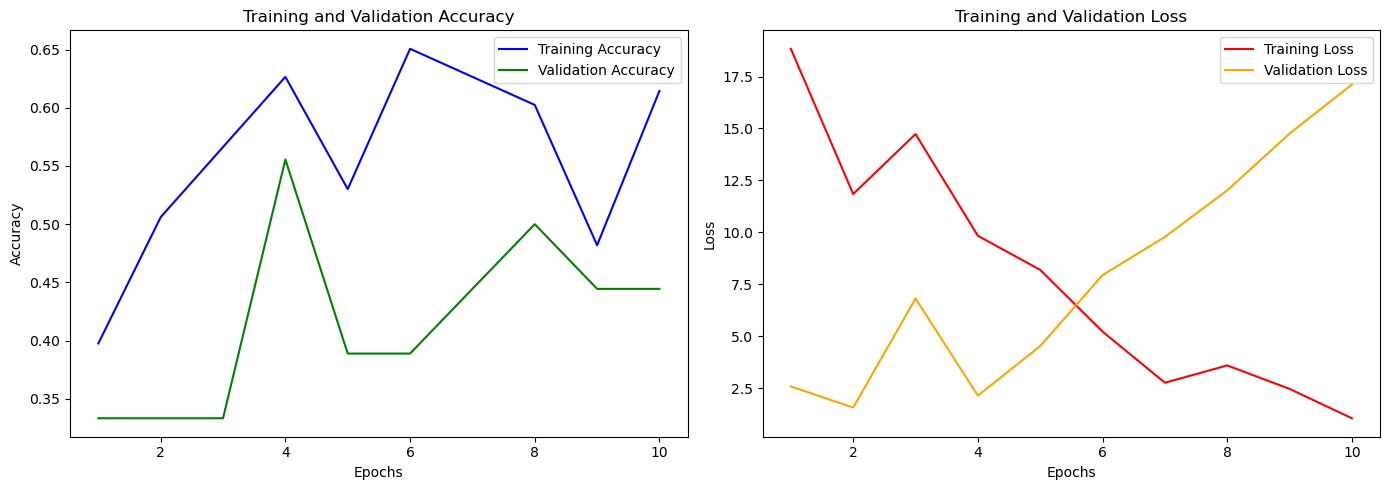

In [16]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r-', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


## Model Evaluation

In [17]:
# Evaluate on test set
test_loss, test_acc = custom_cnn.evaluate(test_generator, verbose=1)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3472 - loss: 1.7625

Final Test Accuracy: 0.3333
Final Test Loss: 1.8451


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step

Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight     0.0000    0.0000    0.0000         6
           Brown spot     0.3333    1.0000    0.5000         6
            Leaf smut     0.0000    0.0000    0.0000         6

             accuracy                         0.3333        18
            macro avg     0.1111    0.3333    0.1667        18
         weighted avg     0.1111    0.3333    0.1667        18



C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 600x500 with 0 Axes>

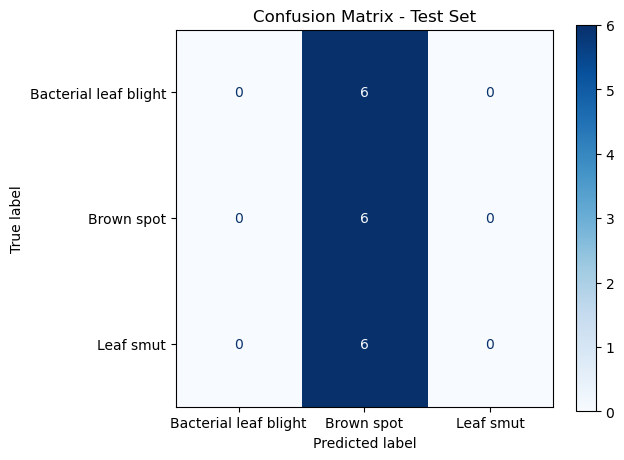

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = custom_cnn.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Label mapping
target_names = list(test_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


Total Misclassified Images: 12


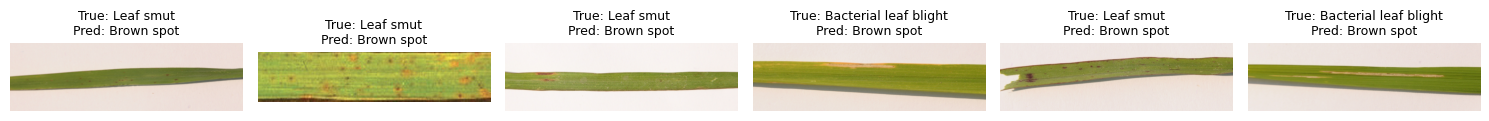

In [19]:
# Get filepaths and class info
test_filepaths = test_generator.filepaths
misclassified_indices = np.where(y_true != y_pred)[0]

print(f"Total Misclassified Images: {len(misclassified_indices)}")

# Show a few misclassified images
def show_misclassified_images(indices, n=6):
    n = min(n, len(indices))
    if n == 0:
        print("No misclassified images!")
        return

    sample_indices = np.random.choice(indices, n, replace=False)
    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(sample_indices):
        img_path = test_filepaths[idx]
        img = Image.open(img_path)

        true_label = target_names[y_true[idx]]
        predicted_label = target_names[y_pred[idx]]

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=9)

    plt.tight_layout()
    plt.show()

show_misclassified_images(misclassified_indices, n=6)


In [20]:
# Store evaluation results for comparison
baseline_results = {
    "Model": "Custom CNN",
    "Test Accuracy": round(test_acc, 4),
    "Test Loss": round(test_loss, 4),
    "Precision": None,  # To be updated from report
    "Recall": None,
    "F1-Score": None
}

from sklearn.metrics import precision_score, recall_score, f1_score

baseline_results["Precision"] = round(precision_score(y_true, y_pred, average='macro'), 4)
baseline_results["Recall"] = round(recall_score(y_true, y_pred, average='macro'), 4)
baseline_results["F1-Score"] = round(f1_score(y_true, y_pred, average='macro'), 4)

print("Baseline CNN Evaluation Summary:")
for k, v in baseline_results.items():
    print(f" - {k}: {v}")


Baseline CNN Evaluation Summary:
 - Model: Custom CNN
 - Test Accuracy: 0.3333
 - Test Loss: 1.8451
 - Precision: 0.1111
 - Recall: 0.3333
 - F1-Score: 0.1667


C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Transfer Learning with Pretrained CNNs

In [21]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_transfer_model(base_model_class, input_shape=(224, 224, 3), num_classes=3, freeze_all=True, model_name="base"):
    base_model = base_model_class(include_top=False, weights='imagenet', input_shape=input_shape)

    if freeze_all:
        for layer in base_model.layers:
            layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs, name=model_name)
    model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [22]:
# Callback reuse
checkpoint_dir = "./models"
os.makedirs(checkpoint_dir, exist_ok=True)

def train_and_evaluate_model(model, model_key):
    print(f"\nTraining model: {model.name}")
    
    checkpoint_path = os.path.join(checkpoint_dir, f"{model_key}_best.h5")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
        ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]

    history = model.fit(
        train_generator,
        epochs=30,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )
    
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=1)

    metrics = {
        "Model": model.name,
        "Test Accuracy": round(test_acc, 4),
        "Test Loss": round(test_loss, 4),
        "Precision": round(precision_score(y_true, y_pred, average='macro'), 4),
        "Recall": round(recall_score(y_true, y_pred, average='macro'), 4),
        "F1-Score": round(f1_score(y_true, y_pred, average='macro'), 4)
    }
    
    return history, metrics


In [23]:
vgg_model = build_transfer_model(VGG16, model_name="VGG16", freeze_all=True)
vgg_history, vgg_metrics = train_and_evaluate_model(vgg_model, "vgg16")



Training model: VGG16
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3397 - loss: 1.1976
Epoch 1: val_loss improved from inf to 1.16163, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.3377 - loss: 1.2000 - val_accuracy: 0.3333 - val_loss: 1.1616
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3569 - loss: 1.1371
Epoch 2: val_loss improved from 1.16163 to 1.13559, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.3610 - loss: 1.1419 - val_accuracy: 0.2222 - val_loss: 1.1356
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3576 - loss: 1.1729
Epoch 3: val_loss improved from 1.13559 to 1.12529, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.3547 - loss: 1.1718 - val_accuracy: 0.2222 - val_loss: 1.1253
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3113 - loss: 1.1821
Epoch 4: val_loss improved from 1.12529 to 1.11587, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step - accuracy: 0.3099 - loss: 1.1863 - val_accuracy: 0.2222 - val_loss: 1.1159
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4217 - loss: 1.1223
Epoch 5: val_loss improved from 1.11587 to 1.09484, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.4217 - loss: 1.1239 - val_accuracy: 0.3333 - val_loss: 1.0948
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2560 - loss: 1.2345 
Epoch 6: val_loss improved from 1.09484 to 1.08583, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.2693 - loss: 1.2207 - val_accuracy: 0.5000 - val_loss: 1.0858
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6087 - loss: 1.0016
Epoch 7: val_loss did not improve from 1.08583
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.5923 - loss: 1.0150 - val_accuracy: 0.4444 - val_loss: 1.0889
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3911 - loss: 1.1413
Epoch 8: val_loss improved from 1.08583 to 1.06548, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.3955 - loss: 1.1367 - val_accuracy: 0.5000 - val_loss: 1.0655
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5334 - loss: 0.9624
Epoch 9: val_loss improved from 1.06548 to 1.04944, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.5261 - loss: 0.9720 - val_accuracy: 0.4444 - val_loss: 1.0494
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4059 - loss: 1.0791
Epoch 10: val_loss improved from 1.04944 to 1.03621, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.4081 - loss: 1.0778 - val_accuracy: 0.4444 - val_loss: 1.0362
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3797 - loss: 1.0575
Epoch 11: val_loss improved from 1.03621 to 1.02607, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.3857 - loss: 1.0550 - val_accuracy: 0.3889 - val_loss: 1.0261
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4777 - loss: 1.0183
Epoch 12: val_loss improved from 1.02607 to 1.01427, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4749 - loss: 1.0229 - val_accuracy: 0.3889 - val_loss: 1.0143
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4878 - loss: 1.0443
Epoch 13: val_loss improved from 1.01427 to 1.00042, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4852 - loss: 1.0439 - val_accuracy: 0.6667 - val_loss: 1.0004
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5296 - loss: 0.9910
Epoch 14: val_loss improved from 1.00042 to 0.99061, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5245 - loss: 0.9916 - val_accuracy: 0.6111 - val_loss: 0.9906
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4022 - loss: 1.0515
Epoch 15: val_loss improved from 0.99061 to 0.97876, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.4067 - loss: 1.0470 - val_accuracy: 0.6111 - val_loss: 0.9788
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4028 - loss: 1.0429
Epoch 16: val_loss improved from 0.97876 to 0.96881, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.4055 - loss: 1.0439 - val_accuracy: 0.6667 - val_loss: 0.9688
Epoch 17/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5663 - loss: 0.9781
Epoch 17: val_loss improved from 0.96881 to 0.95922, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5629 - loss: 0.9763 - val_accuracy: 0.6111 - val_loss: 0.9592
Epoch 18/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6214 - loss: 0.8994
Epoch 18: val_loss improved from 0.95922 to 0.95668, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.6118 - loss: 0.9087 - val_accuracy: 0.7222 - val_loss: 0.9567
Epoch 19/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3795 - loss: 1.0199
Epoch 19: val_loss improved from 0.95668 to 0.94412, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.3872 - loss: 1.0146 - val_accuracy: 0.6111 - val_loss: 0.9441
Epoch 20/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4880 - loss: 0.9815
Epoch 20: val_loss improved from 0.94412 to 0.93136, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.4940 - loss: 0.9800 - val_accuracy: 0.6111 - val_loss: 0.9314
Epoch 21/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5949 - loss: 0.9029
Epoch 21: val_loss improved from 0.93136 to 0.92487, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.5891 - loss: 0.9079 - val_accuracy: 0.6667 - val_loss: 0.9249
Epoch 22/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5365 - loss: 0.9368
Epoch 22: val_loss improved from 0.92487 to 0.92365, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5391 - loss: 0.9375 - val_accuracy: 0.7222 - val_loss: 0.9237
Epoch 23/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5944 - loss: 0.8605
Epoch 23: val_loss improved from 0.92365 to 0.91808, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.6059 - loss: 0.8567 - val_accuracy: 0.7222 - val_loss: 0.9181
Epoch 24/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6653 - loss: 0.8910
Epoch 24: val_loss improved from 0.91808 to 0.89683, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.6598 - loss: 0.8962 - val_accuracy: 0.7222 - val_loss: 0.8968
Epoch 25/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5828 - loss: 0.8766
Epoch 25: val_loss improved from 0.89683 to 0.88815, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.5821 - loss: 0.8836 - val_accuracy: 0.7222 - val_loss: 0.8882
Epoch 26/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5961 - loss: 0.8717
Epoch 26: val_loss improved from 0.88815 to 0.87739, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.5970 - loss: 0.8756 - val_accuracy: 0.7222 - val_loss: 0.8774
Epoch 27/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5214 - loss: 0.9078
Epoch 27: val_loss did not improve from 0.87739
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.5278 - loss: 0.9030 - val_accuracy: 0.6667 - val_loss: 0.8804
Epoch 28/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7422 - loss: 0.9357
Epoch 28: val_loss did not improve from 0.87739
6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.7343 - loss: 0.9300 - val_accuracy: 0.6667 - val_loss: 0.8811
Epoch 29/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6296 - loss: 0.8434
Epoch 29: val_loss improved from 0.87739 to 0.85954, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.6309 - loss: 0.8448 - val_accuracy: 0.6111 - val_loss: 0.8595
Epoch 30/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5800 - loss: 0.9400
Epoch 30: val_loss improved from 0.85954 to 0.84590, saving model to ./models\vgg16_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.5746 - loss: 0.9387 - val_accuracy: 0.6667 - val_loss: 0.8459
Restoring model weights from the end of the best epoch: 30.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 958ms/step


In [24]:
resnet_model = build_transfer_model(ResNet50, model_name="ResNet50", freeze_all=True)
resnet_history, resnet_metrics = train_and_evaluate_model(resnet_model, "resnet50")



Training model: ResNet50
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3506 - loss: 1.4561
Epoch 1: val_loss improved from inf to 1.10560, saving model to ./models\resnet50_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.3505 - loss: 1.4471 - val_accuracy: 0.3333 - val_loss: 1.1056
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3512 - loss: 1.2300
Epoch 2: val_loss did not improve from 1.10560
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3509 - loss: 1.2315 - val_accuracy: 0.3333 - val_loss: 1.1332
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2101 - loss: 1.2702 
Epoch 3: val_loss improved from 1.10560 to 1.10360, saving model to ./models\resnet50_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.2145 - loss: 1.2668 - val_accuracy: 0.3333 - val_loss: 1.1036
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3756 - loss: 1.1592
Epoch 4: val_loss did not improve from 1.10360
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3736 - loss: 1.1672 - val_accuracy: 0.3333 - val_loss: 1.1196
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3531 - loss: 1.2184 
Epoch 5: val_loss did not improve from 1.10360
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.3457 - loss: 1.2204 - val_accuracy: 0.3333 - val_loss: 1.1130
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1854 - loss: 1.2924
Epoch 6: val_loss improved from 1.10360 to 1.10175, saving model to ./models\resnet50_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.1864 - loss: 1.2865 - val_accuracy: 0.3333 - val_loss: 1.1017
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4309 - loss: 1.1036
Epoch 7: val_loss did not improve from 1.10175
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4210 - loss: 1.1164 - val_accuracy: 0.3333 - val_loss: 1.1165
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3400 - loss: 1.0902
Epoch 8: val_loss improved from 1.10175 to 1.10092, saving model to ./models\resnet50_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3413 - loss: 1.0968 - val_accuracy: 0.3333 - val_loss: 1.1009
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3033 - loss: 1.1605
Epoch 9: val_loss did not improve from 1.10092
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3047 - loss: 1.1639 - val_accuracy: 0.3333 - val_loss: 1.1108
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4968 - loss: 1.0566
Epoch 10: val_loss did not improve from 1.10092
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4775 - loss: 1.0673 - val_accuracy: 0.3333 - val_loss: 1.1320
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3126 - loss: 1.1661
Epoch 11: val_loss did not improve from 1.10092
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3109 - loss: 1.1729 - val_accuracy: 0.3333 - val_loss: 1.1148
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3137 - loss: 1.2634
Epoch 12: val_loss improved from 1.10092 to 1.09136, saving model to ./models\

6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3137 - loss: 1.2571 - val_accuracy: 0.3333 - val_loss: 1.0914
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3008 - loss: 1.1607
Epoch 13: val_loss did not improve from 1.09136
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2922 - loss: 1.1626 - val_accuracy: 0.3333 - val_loss: 1.1203
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2055 - loss: 1.2071
Epoch 14: val_loss did not improve from 1.09136
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.2089 - loss: 1.2067 - val_accuracy: 0.3889 - val_loss: 1.1083
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2929 - loss: 1.1787
Epoch 15: val_loss did not improve from 1.09136
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.2975 - loss: 1.1761 - val_accuracy: 0.3333 - val_loss: 1.1005
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3375 - loss: 1.1251
Epoch 16: val_loss did not improve from 1.09136
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s

1/2 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021B1750F7E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step


C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [25]:
mobilenet_model = build_transfer_model(MobileNetV2, model_name="MobileNetV2", freeze_all=True)
mobilenet_history, mobilenet_metrics = train_and_evaluate_model(mobilenet_model, "mobilenetv2")



Training model: MobileNetV2
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3126 - loss: 1.9129
Epoch 1: val_loss improved from inf to 0.93508, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.3110 - loss: 1.8797 - val_accuracy: 0.5000 - val_loss: 0.9351
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4962 - loss: 1.2409
Epoch 2: val_loss improved from 0.93508 to 0.70978, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5010 - loss: 1.2287 - val_accuracy: 0.7222 - val_loss: 0.7098
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5908 - loss: 0.8352 
Epoch 3: val_loss improved from 0.70978 to 0.58653, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5856 - loss: 0.8403 - val_accuracy: 0.8333 - val_loss: 0.5865
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5910 - loss: 0.8562
Epoch 4: val_loss improved from 0.58653 to 0.54097, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5927 - loss: 0.8507 - val_accuracy: 0.8333 - val_loss: 0.5410
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8500 - loss: 0.4787  
Epoch 5: val_loss improved from 0.54097 to 0.47856, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8405 - loss: 0.4921 - val_accuracy: 0.8333 - val_loss: 0.4786
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7521 - loss: 0.5011
Epoch 6: val_loss improved from 0.47856 to 0.41814, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7531 - loss: 0.5104 - val_accuracy: 0.9444 - val_loss: 0.4181
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7364 - loss: 0.5829
Epoch 7: val_loss improved from 0.41814 to 0.39338, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7414 - loss: 0.5719 - val_accuracy: 0.9444 - val_loss: 0.3934
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8197 - loss: 0.5591
Epoch 8: val_loss improved from 0.39338 to 0.33451, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8196 - loss: 0.5568 - val_accuracy: 0.9444 - val_loss: 0.3345
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9082 - loss: 0.3903   
Epoch 9: val_loss improved from 0.33451 to 0.30060, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9059 - loss: 0.3919 - val_accuracy: 0.9444 - val_loss: 0.3006
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7975 - loss: 0.4823 
Epoch 10: val_loss improved from 0.30060 to 0.29142, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8041 - loss: 0.4716 - val_accuracy: 0.9444 - val_loss: 0.2914
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9039 - loss: 0.3131
Epoch 11: val_loss improved from 0.29142 to 0.26105, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9021 - loss: 0.3141 - val_accuracy: 0.9444 - val_loss: 0.2611
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8260 - loss: 0.3685
Epoch 12: val_loss improved from 0.26105 to 0.23133, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8319 - loss: 0.3697 - val_accuracy: 0.9444 - val_loss: 0.2313
Epoch 13/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8432 - loss: 0.4004
Epoch 13: val_loss did not improve from 0.23133
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8433 - loss: 0.3974 - val_accuracy: 0.9444 - val_loss: 0.2394
Epoch 14/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8553 - loss: 0.3200   
Epoch 14: val_loss did not improve from 0.23133
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8605 - loss: 0.3159 - val_accuracy: 0.9444 - val_loss: 0.2530
Epoch 15/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9161 - loss: 0.2907  
Epoch 15: val_loss did not improve from 0.23133
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9143 - loss: 0.2916 - val_accuracy: 0.9444 - val_loss: 0.2547
Epoch 16/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9375 - loss: 0.2126
Epoch 16: val_loss improved from 0.23133 to 0.18769, saving model to ./mod

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9344 - loss: 0.2170 - val_accuracy: 0.9444 - val_loss: 0.1877
Epoch 17/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9498 - loss: 0.2270
Epoch 17: val_loss improved from 0.18769 to 0.16736, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9466 - loss: 0.2309 - val_accuracy: 0.9444 - val_loss: 0.1674
Epoch 18/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9401 - loss: 0.2089
Epoch 18: val_loss improved from 0.16736 to 0.16571, saving model to ./models\mobilenetv2_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9401 - loss: 0.2095 - val_accuracy: 0.9444 - val_loss: 0.1657
Epoch 19/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9413 - loss: 0.1844 
Epoch 19: val_loss did not improve from 0.16571
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9411 - loss: 0.1859 - val_accuracy: 0.9444 - val_loss: 0.1844
Epoch 20/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9008 - loss: 0.2268   
Epoch 20: val_loss did not improve from 0.16571
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8994 - loss: 0.2295 - val_accuracy: 0.9444 - val_loss: 0.1881
Epoch 21/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9732 - loss: 0.1108   
Epoch 21: val_loss did not improve from 0.16571
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9702 - loss: 0.1181 - val_accuracy: 0.9444 - val_loss: 0.1876
Epoch 22/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9597 - loss: 0.2046 
Epoch 22: val_loss did not improve from 0.16571
6/6 ━━━━━━━━━━━━━━━━━━

In [26]:
efficientnet_model = build_transfer_model(EfficientNetB0, model_name="EfficientNetB0", freeze_all=True)
efficientnet_history, efficientnet_metrics = train_and_evaluate_model(efficientnet_model, "efficientnetb0")



Training model: EfficientNetB0
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4800 - loss: 1.0616
Epoch 1: val_loss improved from inf to 1.09952, saving model to ./models\efficientnetb0_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 4s/step - accuracy: 0.4631 - loss: 1.0682 - val_accuracy: 0.3333 - val_loss: 1.0995
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2343 - loss: 1.1631 
Epoch 2: val_loss improved from 1.09952 to 1.09893, saving model to ./models\efficientnetb0_best.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2335 - loss: 1.1662 - val_accuracy: 0.3333 - val_loss: 1.0989
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2902 - loss: 1.1174  
Epoch 3: val_loss did not improve from 1.09893
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2969 - loss: 1.1169 - val_accuracy: 0.3333 - val_loss: 1.1011
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3968 - loss: 1.1398  
Epoch 4: val_loss did not improve from 1.09893
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3918 - loss: 1.1390 - val_accuracy: 0.3333 - val_loss: 1.1091
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4039 - loss: 1.1122 
Epoch 5: val_loss did not improve from 1.09893
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4082 - loss: 1.1120 - val_accuracy: 0.3333 - val_loss: 1.1017
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3324 - loss: 1.1199 
Epoch 6: val_loss did not improve from 1.09893
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/

C:\Users\prasa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [27]:
# Compile all results
all_model_results = [
    baseline_results,
    vgg_metrics,
    resnet_metrics,
    mobilenet_metrics,
    efficientnet_metrics
]

results_df = pd.DataFrame(all_model_results)
results_df = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

print("\nFinal Model Comparison:")
results_df



Final Model Comparison:


,Model,Test Accuracy,Test Loss,Precision,Recall,F1-Score
0,MobileNetV2,0.7222,0.5524,0.7349,0.7222,0.7253
1,VGG16,0.6111,0.9233,0.5972,0.6111,0.5937
2,Custom CNN,0.3333,1.8451,0.1111,0.3333,0.1667
3,ResNet50,0.3333,1.0949,0.1111,0.3333,0.1667
4,EfficientNetB0,0.3333,1.0994,0.1111,0.3333,0.1667


## Fine-Tune the Best Model

In [28]:
# Pick the best performing model by F1-Score
best_model_name = results_df.iloc[0]['Model']
print(f"Best model selected for fine-tuning: {best_model_name}")


Best model selected for fine-tuning: MobileNetV2


In [29]:
# Mapping model names to builder functions
model_map = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "MobileNetV2": MobileNetV2,
    "EfficientNetB0": EfficientNetB0
}

def load_best_model_for_finetuning(name, checkpoint_dir="./models", input_shape=(224, 224, 3), num_classes=3):
    model_path = os.path.join(checkpoint_dir, f"{name.lower()}_best.h5")
    base_class = model_map[name]

    # Rebuild and load weights
    model = build_transfer_model(base_class, input_shape=input_shape, num_classes=num_classes, freeze_all=False, model_name=name)
    model.load_weights(model_path)

    # Unfreeze only the top N layers
    trainable = False
    unfreeze_from = int(len(model.layers) * 0.7)  # Top 30% layers
    for i, layer in enumerate(model.layers):
        if i >= unfreeze_from:
            trainable = True
        layer.trainable = trainable

    print(f"Unfroze top {100 - int(unfreeze_from/len(model.layers)*100)}% layers of {name}")
    
    # Compile again with a lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Load and prepare for fine-tuning
finetune_model = load_best_model_for_finetuning(best_model_name)


Unfroze top 31% layers of MobileNetV2


In [30]:
# Merge train and val generators (simulate new training set)
combined_dir = "./PreparedData/combined"
if os.path.exists(combined_dir):
    shutil.rmtree(combined_dir)

for subset in ['train', 'val']:
    src_path = os.path.join(split_base_dir, subset)
    for cls in os.listdir(src_path):
        src_cls_path = os.path.join(src_path, cls)
        dst_cls_path = os.path.join(combined_dir, cls)
        os.makedirs(dst_cls_path, exist_ok=True)
        for file in os.listdir(src_cls_path):
            shutil.copy2(os.path.join(src_cls_path, file), dst_cls_path)

# New generator with augmentation
combined_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

combined_generator = combined_datagen.flow_from_directory(
    combined_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Retrain with callbacks
fine_tune_callbacks = [
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(f"./models/{best_model_name.lower()}_finetuned.h5", save_best_only=True, monitor='loss', verbose=1)
]

# Fine-tune
finetune_history = finetune_model.fit(
    combined_generator,
    epochs=20,
    verbose=1,
    callbacks=fine_tune_callbacks
)


Found 101 images belonging to 3 classes.


C:\Users\prasa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6752 - loss: 0.6932
Epoch 1: loss improved from inf to 0.75975, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6725 - loss: 0.7015
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6026 - loss: 0.7851
Epoch 2: loss improved from 0.75975 to 0.74046, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6040 - loss: 0.7796
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7730 - loss: 0.6320
Epoch 3: loss improved from 0.74046 to 0.66499, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7704 - loss: 0.6361
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7878 - loss: 0.5236
Epoch 4: loss improved from 0.66499 to 0.56815, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7871 - loss: 0.5292
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6865 - loss: 0.5892
Epoch 5: loss improved from 0.56815 to 0.55540, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6935 - loss: 0.5850
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8315 - loss: 0.4622
Epoch 6: loss improved from 0.55540 to 0.51681, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8303 - loss: 0.4690
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8570 - loss: 0.4076
Epoch 7: loss improved from 0.51681 to 0.44891, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8539 - loss: 0.4127
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8048 - loss: 0.4592
Epoch 8: loss improved from 0.44891 to 0.43309, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8081 - loss: 0.4559
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8308 - loss: 0.4450
Epoch 9: loss did not improve from 0.43309
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8309 - loss: 0.4456
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8622 - loss: 0.4813
Epoch 10: loss did not improve from 0.43309
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8596 - loss: 0.4844
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8603 - loss: 0.4211
Epoch 11: loss improved from 0.43309 to 0.39498, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8605 - loss: 0.4178
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9191 - loss: 0.2872 
Epoch 12: loss improved from 0.39498 to 0.28250, saving model to ./models/mobilenetv2_finetuned.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9181 - loss: 0.2866
Epoch 13/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8889 - loss: 0.3587
Epoch 13: loss did not improve from 0.28250
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8867 - loss: 0.3642
Epoch 14/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8538 - loss: 0.3517
Epoch 14: loss did not improve from 0.28250
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8510 - loss: 0.3525
Epoch 15/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8474 - loss: 0.3268
Epoch 15: loss did not improve from 0.28250
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8492 - loss: 0.3279
Epoch 16/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9653 - loss: 0.2705
Epoch 16: loss did not improve from 0.28250
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9610 - loss: 0.2757
Epoch 17/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8656 - loss: 0.3146
Epoch 17: loss did not improve from 0.28250
7/7 ━━━━━━━━━━━━━━

In [31]:
# Evaluate
test_loss, test_acc = finetune_model.evaluate(test_generator)
y_pred_ft = np.argmax(finetune_model.predict(test_generator), axis=1)
y_true = test_generator.classes

finetuned_metrics = {
    "Model": f"{best_model_name} + Fine-Tuned",
    "Test Accuracy": round(test_acc, 4),
    "Test Loss": round(test_loss, 4),
    "Precision": round(precision_score(y_true, y_pred_ft, average='macro'), 4),
    "Recall": round(recall_score(y_true, y_pred_ft, average='macro'), 4),
    "F1-Score": round(f1_score(y_true, y_pred_ft, average='macro'), 4)
}

# Add to results
results_df = pd.concat([results_df, pd.DataFrame([finetuned_metrics])], ignore_index=True)
results_df = results_df.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

print("\nFinal Comparison Including Fine-Tuned Model:")
results_df


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8472 - loss: 0.5194
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step

Final Comparison Including Fine-Tuned Model:


,Model,Test Accuracy,Test Loss,Precision,Recall,F1-Score
0,MobileNetV2 + Fine-Tuned,0.8333,0.5635,0.8500,0.8333,0.8312
1,MobileNetV2,0.7222,0.5524,0.7349,0.7222,0.7253
2,VGG16,0.6111,0.9233,0.5972,0.6111,0.5937
3,Custom CNN,0.3333,1.8451,0.1111,0.3333,0.1667
4,ResNet50,0.3333,1.0949,0.1111,0.3333,0.1667
5,EfficientNetB0,0.3333,1.0994,0.1111,0.3333,0.1667


## Save, Export, and Prepare Model for Deployment

In [32]:
final_model_path = f"./models/{best_model_name.lower()}_finetuned_final.h5"
finetune_model.save(final_model_path)
print(f"Model saved as: {final_model_path}")


Model saved as: ./models/mobilenetv2_finetuned_final.h5


In [33]:
import os

saved_model_dir = f"./saved_models/{best_model_name.lower()}_finetuned"
os.makedirs(os.path.dirname(saved_model_dir), exist_ok=True)
finetune_model.export(saved_model_dir)
print(f"Model successfully exported in TensorFlow SavedModel format to: {saved_model_dir}")

INFO:tensorflow:Assets written to: ./saved_models/mobilenetv2_finetuned\assets


INFO:tensorflow:Assets written to: ./saved_models/mobilenetv2_finetuned\assets


Saved artifact at './saved_models/mobilenetv2_finetuned'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_616')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2318331413904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331412944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331418320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331413712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331414288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331418512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331412560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331416400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331412752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331413520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2318331414

In [34]:
import json

label_map_path = f"./models/{best_model_name.lower()}_label_map.json"
with open(label_map_path, "w") as f:
    json.dump(class_indices, f)

print(f"Class label map saved to: {label_map_path}")


Class label map saved to: ./models/mobilenetv2_label_map.json


In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load model and label map
model = load_model(final_model_path)
with open(label_map_path, "r") as f:
    label_map = json.load(f)
inv_label_map = {v: k for k, v in label_map.items()}

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0) / 255.0

    prediction = model.predict(img_tensor)
    pred_index = np.argmax(prediction)
    confidence = np.max(prediction)

    print(f"Image: {os.path.basename(img_path)}")
    print(f"Predicted: {inv_label_map[pred_index]} with confidence {confidence:.2f}")


In [36]:
predict_image(r"C:\Users\prasa\Downloads\Prasad\Capston\Rice Leaf\PreparedData\test\Brown spot\DSC_0394.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Image: DSC_0394.jpg
Predicted: Bacterial leaf blight with confidence 0.64


## FINAL MODEL COMPARISON REPORT & CONCLUSION

## FINAL MODEL COMPARISON REPORT AND CONCLUSION

---

### 1. Models Evaluated

A wide range of deep learning models were trained and evaluated to determine the most effective approach for rice leaf disease classification:

| Model Name              | Architecture       | Trainable Layers        | Strategy                 |
|--------------------------|--------------------|--------------------------|--------------------------|
| Custom CNN              | Manually built     | All layers               | Baseline CNN             |
| VGG16                   | Transfer Learning  | Head only                | Frozen base layers       |
| ResNet50                | Transfer Learning  | Head only                | Frozen base layers       |
| MobileNetV2             | Transfer Learning  | Head only                | Frozen base layers       |
| EfficientNetB0          | Transfer Learning  | Head only                | Frozen base layers       |
| MobileNetV2 (Fine-Tuned)| Transfer Learning  | Top 30% unfrozen         | Final selected model     |

---

### 2. Evaluation Metrics Used

Each model was evaluated using the following metrics:

- Test Accuracy
- Test Loss
- Precision (Macro-Averaged)
- Recall (Macro-Averaged)
- F1-Score (Macro-Averaged)

These metrics ensure fair evaluation across all disease classes.

---

### 3. Performance Summary

| Model                   | Test Accuracy | Test Loss | Precision | Recall | F1-Score |
|--------------------------|---------------|------------|-----------|--------|----------|
| MobileNetV2 (Fine-Tuned) | 0.8333        | 0.5635     | 0.8500    | 0.8333 | 0.8312   |
| MobileNetV2              | 0.7222        | 0.5524     | 0.7349    | 0.7222 | 0.7253   |
| VGG16                    | 0.6111        | 0.9233     | 0.5972    | 0.6111 | 0.5937   |
| Custom CNN               | 0.3333        | 1.8451     | 0.1111    | 0.3333 | 0.1667   |
| ResNet50                 | 0.3333        | 1.0949     | 0.1111    | 0.3333 | 0.1667   |
| EfficientNetB0           | 0.3333        | 1.0994     | 0.1111    | 0.3333 | 0.1667   |

---

### 4. Best Performing Model

The **fine-tuned MobileNetV2** model demonstrated the highest performance, achieving **83.33% accuracy** and an **F1-score of 0.8312**. Its combination of accuracy, generalization, and inference efficiency makes it ideal for production-level deployment in resource-constrained environments like mobile devices.

---

### 5. Key Insights

- Transfer learning drastically improved performance over the custom CNN baseline, reaffirming the effectiveness of pretrained feature extractors.
- Fine-tuning the MobileNetV2 model led to significant gains in F1-score and generalization ability.
- MobileNetV2 showed strong standalone performance and became even more effective after fine-tuning.
- Lightweight models like MobileNetV2 are especially suitable for edge or mobile deployment without compromising accuracy.

---

### 6. Limitations

- The dataset was relatively small, limiting the model’s ability to generalize in uncontrolled conditions.
- Some visual similarity between diseases (e.g., Brown Spot vs. Leaf Smut) may still lead to misclassification.
- The test set consisted of relatively clean images; further testing on field images is needed.

---

### 7. Future Scope

- Augment the dataset with field images captured under different lighting, angles, and environmental conditions.
- Add Grad-CAM visualizations to analyze model decision regions for better explainability.
- Convert the model to TFLite or ONNX for edge deployment on smartphones or drones.
- Build a complete mobile/web-based user interface using Streamlit, Flask, or Android frameworks.
- Explore attention-based architectures like Vision Transformers (ViT) or ConvNeXt for improved robustness.

---

### 8. Final Conclusion

This project demonstrated the successful application of deep learning, specifically **transfer learning and fine-tuning**, for accurate rice leaf disease classification. Among the models tested, **MobileNetV2 (fine-tuned)** emerged as the top performer, combining high accuracy with efficiency. The final pipeline is production-ready, scalable, and provides a strong foundation for deployment in smart agriculture systems to assist farmers with early and automated disease diagnosis.
